In [313]:
from qiskit import QuantumCircuit, transpile
from qiskit import BasicAer, assemble
from qiskit.visualization import plot_histogram
from qaci.blocks.mcz import mcz
from qaci.helpers.bools import int_to_boollist
import math
import matplotlib.pyplot as plt

In [314]:

def diffuser(nqubits, asGate:bool = True):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    if asGate:
        U_s = qc.to_gate()
        U_s.name = "diffuser"
        return U_s
    return qc

In [315]:
# def x_diffusers( x:int, nqubits:int=3):
#     qc = QuantumCircuit(nqubits)
#     for _ in range(x):
#         qc.append(diffuser(nqubits), range(nqubits))
    
#     return transpile(qc, optimization_level=3)

# # import matplotlib.pyplot as plt
# # plt.plot([len(x_diffusers(x)) for x in range(1, 10)])
# # plt.ylabel('circuit complexity')
# # plt.show()

# x_diffusers(3).draw()

In [316]:
def sample_oracle(nqubits, marked_states:int=1, asGate:bool = True):
    qc = QuantumCircuit(nqubits)
    for i in range(marked_states):
        not_gates_at = int_to_boollist(i)
        for pos, val in enumerate(not_gates_at):
            if val:
                qc.x(pos)
        qc.append(mcz(nqubits), range(nqubits))  # multi-controlled-z (we mark the 111111.. state)
        for pos, val in enumerate(not_gates_at):
            if val:
                qc.x(pos)

    if asGate:
        U_s = qc.to_gate()
        U_s.name = "oracle"
        return U_s
    return qc

In [317]:
def amp_amp(sample_oracle, marked_states:int = 1, nqubits:int=3, ):
    qc = QuantumCircuit(nqubits)
    qc.h(range(nqubits))
    if marked_states > 0:
        i = 0
        while i <= math.sqrt(2**nqubits/marked_states)*math.pi/4:
            qc.append(sample_oracle(nqubits), range(nqubits))
            qc.append(diffuser(nqubits), range(nqubits))
            i += 1
    # qc.measure_all()
    return qc


In [318]:
nqubits=4
circuit = amp_amp(sample_oracle,nqubits)

In [319]:
circuit.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐
q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├
     ├───┤│         ││           ││         ││           │
q_1: ┤ H ├┤1 oracle ├┤1 diffuser ├┤1 oracle ├┤1 diffuser ├
     ├───┤│         ││           ││         ││           │
q_2: ┤ H ├┤2        ├┤2          ├┤2        ├┤2          ├
     └───┘└─────────┘└───────────┘└─────────┘└───────────┘

In [320]:
def unitary_transpile(circuit):    
    sim =  BasicAer.get_backend("unitary_simulator")
    result = sim.run(assemble(transpile(circuit, sim))).result()
    unitary = result.get_unitary()
    nqubits = len(circuit.qubits)#int(math.log2(unitary.shape[0]))
    uCircuit = QuantumCircuit(nqubits)
    uCircuit.unitary(unitary, range(nqubits))
    tuCircuit = transpile(uCircuit, optimization_level=3)
    return tuCircuit



In [321]:
ucircuit = unitary_transpile(circuit)
ucircuit.draw()


┌─────────────────┐                                            »
q_0: ┤0                ├──■──────────────────────────────────────■──»
     │  circuit-226342 │  │                                      │  »
q_1: ┤1                ├──┼───────────────────■──────────────────┼──»
     └─┬──────────────┬┘┌─┴─┐┌─────────────┐┌─┴─┐┌────────────┐┌─┴─┐»
q_2: ──┤ U(0,0,-3π/4) ├─┤ X ├┤ U(0,0,-π/4) ├┤ X ├┤ U(0,0,π/4) ├┤ X ├»
       └──────────────┘ └───┘└─────────────┘└───┘└────────────┘└───┘»
«                         ┌─────────────────┐                                  »
«q_0: ────────────────────┤0                ├─────────────────■────────────────»
«                         │  circuit-226351 │                 │                »
«q_1: ─────────────────■──┤1                ├─────────────────┼────────────────»
«     ┌─────────────┐┌─┴─┐├─────────────────┴┐┌────────────┐┌─┴─┐┌────────────┐»
«q_2: ┤ U(0,0,-π/4) ├┤ X ├┤ U(7π/12,0.0,0.0) ├┤ U(π/2,0,π) ├┤ X ├┤ U(π/2,0,π) ├»
«     └─────────────┘└───┘└──────────────────┘└────────────┘└───┘└────────────┘»
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ─────────────────────────────────────────────────■────────────────»
«     ┌───────────────────────────────┐┌────────────┐┌─┴─┐┌────────────┐»
«q_2: ┤ U(-0.361367123906708,0.0,0.0) ├┤ U(π/2,0,π) ├┤ X ├┤ U(π/2,0,π) ├»
«     └───────────────────────────────┘└────────────┘└───┘└────────────┘»
«                                           ┌─────────────────┐»
«q_0: ───────────────────────────────────■──┤0                ├»
«                                        │  │  circuit-226360 │»
«q_1: ───────────────────────────────────┼──┤1                ├»
«     ┌─────────────────┐┌────────────┐┌─┴─┐└──┬────────────┬─┘»
«q_2: ┤ U(π/12,0.0,0.0) ├┤ U(π/2,0,π) ├┤ X ├───┤ U(π/2,0,π) ├──»
«     └─────────────────┘└────────────┘└───┘   └────────────┘  »
«                                                                            »
«q_0: ─────────────────────────────────────────────────■─────────────────────»
«                                                      │                     »
«q_1: ─────────────────────────────────────────────────┼──────────────────■──»
«     ┌───────────────────────────────┐┌────────────┐┌─┴─┐┌────────────┐┌─┴─┐»
«q_2: ┤ U(-0.361367123906708,0.0,0.0) ├┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,π/4) ├┤ X ├»
«     └───────────────────────────────┘└────────────┘└───┘└────────────┘└───┘»
«                                                                      »
«q_0: ──────────────────────────────■──────────────────────────────────»
«                                   │                                  »
«q_1: ──────────────────────────────┼───────────────────────────────■──»
«     ┌──────────────────────────┐┌─┴─┐┌─────────────────────────┐┌─┴─┐»
«q_2: ┤ U(0,0,0.428535973925065) ├┤ X ├┤ U(0,0,1.14226035286983) ├┤ X ├»
«     └──────────────────────────┘└───┘└─────────────────────────┘└───┘»
«     ┌─────────────────┐
«q_0: ┤0                ├
«     │  circuit-226371 │
«q_1: ┤1                ├
«     └─────────────────┘
«q_2: ───────────────────
«

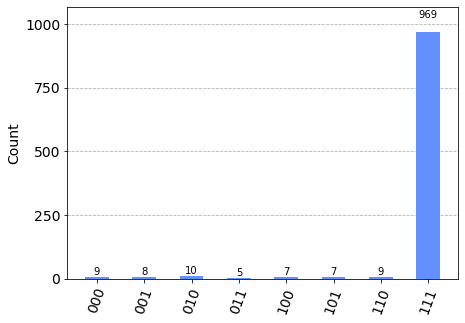

In [322]:
sim =  BasicAer.get_backend("qasm_simulator")
circuit.measure_all()
result = sim.run(assemble(transpile(circuit, sim))).result()
plot_histogram(result.get_counts())

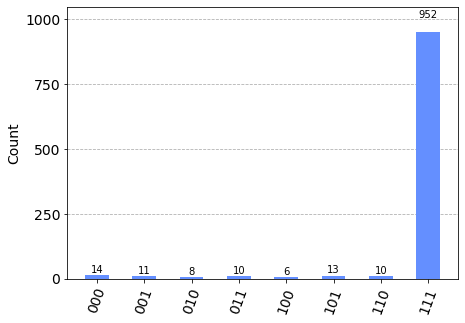

In [323]:
sim =  BasicAer.get_backend("qasm_simulator")
ucircuit.measure_all()
result = sim.run(assemble(transpile(ucircuit, sim))).result()
plot_histogram(result.get_counts())

In [324]:
def x_diffusers( x:int, nqubits:int=3):
    qc = QuantumCircuit(nqubits)
    for _ in range(x):
        qc += diffuser(nqubits, asGate=False)
    
    return transpile(qc, optimization_level=0)


# x_diffusers(3).draw()

/var/folders/36/cw997w5d6rlg1zg94lrrddl40000gn/T/ipykernel_63376/1671760714.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += diffuser(nqubits, asGate=False)


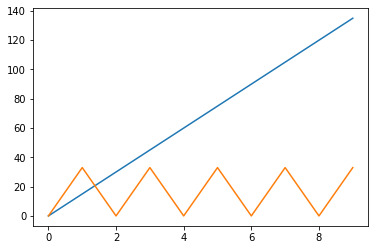

In [325]:
x = range(10)
y = [len(x_diffusers(ix)) for ix in x]
y2 = [len(unitary_transpile(x_diffusers(ix))) for ix in x]
fig, ax = plt.subplots()
ax.plot(x,y)
ax.plot(x,y2)
plt.show()

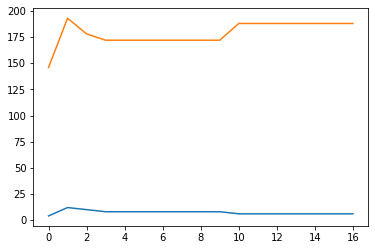

In [326]:

x = range(2**nqubits+1)
circuits = [amp_amp(sample_oracle, ix,nqubits) for ix in x]
y = [len(circuits[ix]) for ix in x]
y2 = [len(unitary_transpile(circuits[ix])) for ix in x]
fig, ax = plt.subplots()
# ax.semilogy(x, y)
# ax.semilogy(x, y2)
ax.plot(x,y)
ax.plot(x,y2)
plt.show()

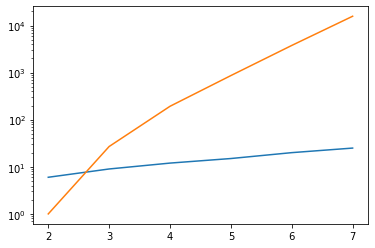

In [329]:
start=2
x = range(start,8)
circuits = [amp_amp(sample_oracle, 1,ix) for ix in x]
y = [len(circuits[ix-start]) for ix in x]
y2 = [len(unitary_transpile(circuits[ix-start])) for ix in x]
fig, ax = plt.subplots()
ax.semilogy(x, y)
ax.semilogy(x, y2)
# ax.plot(x,y)
# ax.plot(x,y2)